# Target Leakage in Machine Learning

© Yuriy Guts, 2018

## Example 01: Data Collection Stage

In this example, we will explore how including the features that strongly describe the target but are not available at prediction time affect our confidence in the out-of-sample performance of our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import xgboost as xgb

In [3]:
from sklearn.model_selection import KFold, cross_val_score

In [4]:
%matplotlib inline

### Read Data

Let's load the (slightly modified) [semi-annual Ukrainian developer salary survey](https://github.com/imax/dou-salaries/).

In [5]:
df = pd.read_csv('data/dou-ua-engineer-salaries-2018-eng.csv')

In [6]:
df.dtypes

Age                             int64
AnnualIncomeUSD                 int64
City                           object
CompanySize                    object
CompanyType                    object
CurrentWorkplaceExperience    float64
Domain                         object
Education                      object
EnglishLevel                   object
IsStudyingCurrently              bool
JobTitle                       object
MonthlySalaryUAH                int64
ProgrammingLanguage            object
ResponseDate                   object
Sex                            object
Specialization                float64
TotalWorkExperience           float64
University                     object
UserAgent                      object
dtype: object

## Encode Features

Seniority, company size, education, and english level can be derived as ordinal features.

In [7]:
df['Seniority'] = df['JobTitle'].map({
    'Junior Software Engineer': 1,
    'Software Engineer': 2,
    'Senior Software Engineer': 3,
}).astype(int)

In [8]:
df['CompanySize'] = df['CompanySize'].map({
    '1-10 employees': 1,
    '11-50 employees': 2,
    '51-200 employees': 3,
    '201-1000 employees': 4,
    '1001+ employees': 5,
}).astype(int)

In [9]:
df['Education'] = df['Education'].map({
    'Secondary': 1,
    'Vocational': 2,
    'Unfinished higher': 3,
    'Higher': 4,
    'Two higher': 5,
    'Postgraduate': 6,
}).astype(int)

In [10]:
df['EnglishLevel'] = df['EnglishLevel'].map({
    'Elementary': 1,
    'Pre-Intermediate': 2,
    'Intermediate': 3,
    'Upper-Intermediate': 4,
    'Advanced': 5,
}).astype(int)

In [11]:
df['IsFemale'] = pd.get_dummies(df['Sex'])['female'].astype(int)

One-hot encode the company type.

In [12]:
df[['CompanyTypeOther', 'CompanyTypeOutsourcing', 'CompanyTypeOutstaffing',
    'CompanyTypeProduct', 'CompanyTypeStartup']] = pd.get_dummies(df['CompanyType']).astype(int)

Let's not bother with encoding some features in this example, just remove them.

In [13]:
df.drop(['City', 'CompanyType', 'Domain', 'JobTitle', 'ProgrammingLanguage',
         'ResponseDate', 'Sex', 'Specialization', 'University', 'UserAgent'],
        axis=1, inplace=True)

In [14]:
df.dtypes

Age                             int64
AnnualIncomeUSD                 int64
CompanySize                     int64
CurrentWorkplaceExperience    float64
Education                       int64
EnglishLevel                    int64
IsStudyingCurrently              bool
MonthlySalaryUAH                int64
TotalWorkExperience           float64
Seniority                       int64
IsFemale                        int64
CompanyTypeOther                int64
CompanyTypeOutsourcing          int64
CompanyTypeOutstaffing          int64
CompanyTypeProduct              int64
CompanyTypeStartup              int64
dtype: object

In [15]:
df.isnull().sum()

Age                           0
AnnualIncomeUSD               0
CompanySize                   0
CurrentWorkplaceExperience    0
Education                     0
EnglishLevel                  0
IsStudyingCurrently           0
MonthlySalaryUAH              0
TotalWorkExperience           0
Seniority                     0
IsFemale                      0
CompanyTypeOther              0
CompanyTypeOutsourcing        0
CompanyTypeOutstaffing        0
CompanyTypeProduct            0
CompanyTypeStartup            0
dtype: int64

In [16]:
df.head(5)

,Age,AnnualIncomeUSD,CompanySize,CurrentWorkplaceExperience,Education,EnglishLevel,IsStudyingCurrently,MonthlySalaryUAH,TotalWorkExperience,Seniority,IsFemale,CompanyTypeOther,CompanyTypeOutsourcing,CompanyTypeOutstaffing,CompanyTypeProduct,CompanyTypeStartup
0,37,6000,2,10.0,4,2,False,14000,10.0,2,0,1,0,0,0,0
1,23,24000,2,2.0,4,4,False,56000,3.0,2,0,0,0,0,1,0
2,27,45000,3,0.0,2,3,False,105000,3.0,3,0,0,1,0,0,0
3,23,18000,3,2.0,4,3,False,42000,2.0,2,0,0,0,0,1,0
4,27,43200,4,0.5,4,4,False,100800,6.0,2,0,0,0,0,1,0


Everything looks clean, let's now train and cross-validate the model.

### Train and Evaluate Model

In [17]:
y = df['AnnualIncomeUSD']

In [18]:
X = df.drop(['AnnualIncomeUSD'], axis=1)

In [19]:
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, objective='reg:linear')

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=12345)
cross_val_score(model, X, y, scoring='explained_variance', cv=cv)

array([0.99983496, 0.99724655, 0.99999476, 0.99310043, 0.9999892 ])

**Uuuummmm, what?** The score is almost perfect – too good to be true. Let's check XGBoost feature importances.

In [21]:
model.fit(X, y)
importances = model.get_booster().get_score(importance_type='gain')

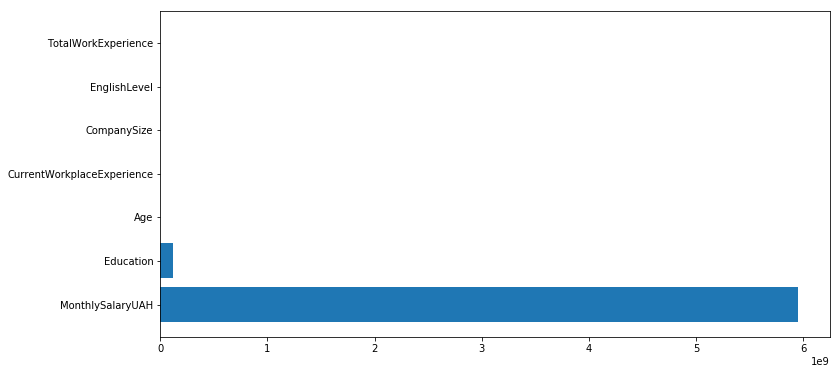

In [22]:
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), list(importances.values()), align='center')
plt.yticks(range(len(importances)), list(importances.keys()))
plt.show()

MonthlySalaryUAH is in another resolution and another currency. But we will not know it at prediction time (the person is not employed there yet).

### Fix Leakage

Let's remove the leaky feature.

In [23]:
X = X.drop(['MonthlySalaryUAH'], axis=1)

In [24]:
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, objective='reg:linear')

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=12345)
cross_val_score(model, X, y, scoring='explained_variance', cv=cv)

array([0.71805016, 0.74558753, 0.69448406, 0.72093215, 0.71447403])

Now everything looks much more reasonable.

In [26]:
model.fit(X, y)
importances = model.get_booster().get_score(importance_type='gain')

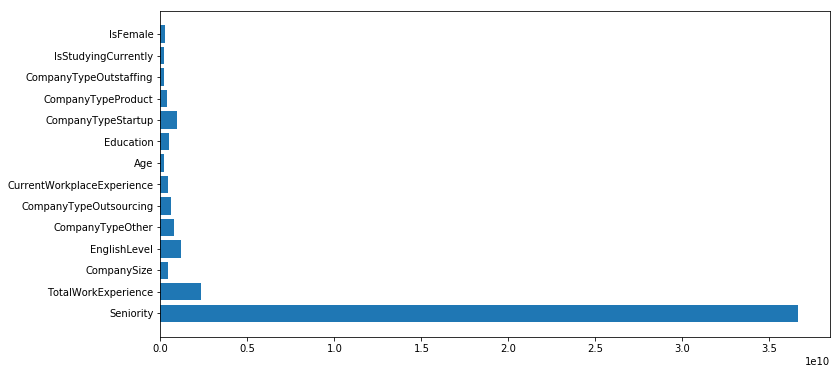

In [27]:
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), list(importances.values()), align='center')
plt.yticks(range(len(importances)), list(importances.keys()))
plt.show()

Top features now make a lot of sense from the domain point of view.